In [79]:
from gen_label_and_prob import read_gray, resize_ndarray, read_npy, DenseCRF
from act_tools import act_tanh2, act_trough, act_trough2, act_trough3, edge2positions, act_valley, act_linear
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import cv2

In [80]:
root = "../../data/DiffuseMade10"
ann_suffix = ".png"
# ann_suffix = ".npy"
img_suffix = ".png"
ann_dir = osp.join(root, "cross_dir/train")
# ann_dir = osp.join(root, "combine_dir/train")
img_dir = osp.join(root, "img_dir/train")
# name = "00001134"
# name = "00002216"
# name = "00004212"
# name = "00000757"
# name = "00005581"
# name = "00005587"
# name = "00000008"
# name = "00000028"
# name = "00001028"
# name = "00002028"
name = "00003028"
name = "00003029"
name = "00003030"
name = "00003031"
name = "00003032"
# name = "00004028"
# name = "00005405"
# name = "00006028"
# name = "00007028"
# name = "00008028"
# name = "00009028"
# name = "00010035"
# name = "00011028"
# name = "00012029"
# name = "00013030"
# name = "00014028"
# name = "00014030"
# name = "00015029"
# name = "00016028"
# name = "00017036"
# name = "00018029"
# name = "00019030"
# name = "00019031"
name = "00001133"
name = "00002530"
name = "00002622"
name = "00000194"
name = "00001998"
name = "00010332"
name = "00003451"

win_size = 0.20
mid = 0.25
th = 5000
sat = 4.0
mean_bgr = (104.008, 116.669, 122.675)
low_th = 0.05
high_th = 0.95
bins = 100
sigma = 1.0

if ann_suffix == '.png':
    ann_reader = read_gray
else:
    ann_reader = read_npy

In [81]:
ann_path = os.path.join(ann_dir, f"{name}{ann_suffix}")
img_path = os.path.join(img_dir, f"{name}.png")
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = img_bgr[:, :, ::-1]
gray_ann = ann_reader(ann_path).astype(np.float32)
gray_ann = resize_ndarray(gray_ann, size=(512, 512), mode='bilinear')
prob = gray_ann / 255.0

In [82]:
def show_img(img):
    plt.imshow(img)
    plt.show()


def show_prob(prob):
    plt.imshow(prob, cmap="gray", vmin=0, vmax=1)
    plt.show()


def show_hist(hist_info, crest_info, trough_info, mid, part_trough_positions, th):
    # hist, bin_edges = np.histogram(prob, bins=100, range=(0, 1))
    # positions = edge2positions(bin_edges)
    # crests, crest_positions = find_crests(hist, positions, window_size=win_size, is_trough=False, threshold=th)
    # troughs, trough_positions = find_crests(hist, positions, window_size=win_size, is_trough=True, threshold=th)
    plt.stairs(*hist_info)
    plt.scatter(*crest_info, label='crest')
    plt.scatter(*trough_info, label='trough')
    plt.axvline(mid, ls='--')
    if part_trough_positions is not None:
        plt.axvline(part_trough_positions[0], ls=':')
        plt.axvline(part_trough_positions[-1], ls=':')
    if th is not None:
        plt.axhline(th)
    plt.legend()
    plt.show()


def show_hist2(hist, bin_edges, peak_idx=None, valley_idx=None):
    plt.stairs(hist, bin_edges)
    positions = None
    if peak_idx is not None or valley_idx is not None:
        positions = edge2positions(bin_edges)
    if peak_idx is not None:
        plt.plot(positions[peak_idx], hist[peak_idx], 'x', label='peaks')
    if valley_idx is not None:
        plt.plot(positions[valley_idx], hist[valley_idx], 'o', label='valleys')
    if positions is not None:
        plt.legend()
    plt.show()


In [83]:
postprocess = DenseCRF(iter_max=10,
                       pos_xy_std=1,  # 1
                       pos_w=3,
                       bi_xy_std=67,  # 67
                       bi_rgb_std=3,  # 3
                       bi_w=4, )


def do_postprocess(prob, img_bgr):
    prob = np.stack([1 - prob, prob], axis=0)
    img_f = img_bgr.astype(np.float32)
    img_f -= mean_bgr
    img = img_f.astype(np.uint8)
    prob = postprocess(img, prob)
    prob = prob[1]
    return prob


def ternaryzation(prob, low_th, high_th):
    is_fore = prob < low_th
    is_back = prob > high_th
    is_ignored = ~(is_back | is_fore)
    label = np.zeros(prob.shape, dtype=np.uint8)
    label[is_fore] = 128
    label[is_back] = 0
    label[is_ignored] = 255
    return label


def show_img_with_label(img, label, label_ratio=0.7):
    show_img = img.copy().astype(np.float32)
    is_fore = label == 128
    is_back = label == 0
    is_ignored = label == 255
    show_img *= (1 - label_ratio)
    show_img[is_fore] += np.array([255, 0, 0]) * label_ratio
    show_img[is_back] += np.array([0, 0, 0]) * label_ratio
    show_img[is_fore] += np.array([255, 255, 255]) * label_ratio
    show_img = show_img.astype(np.uint8)
    plt.imshow(show_img)
    plt.show()

## Origin

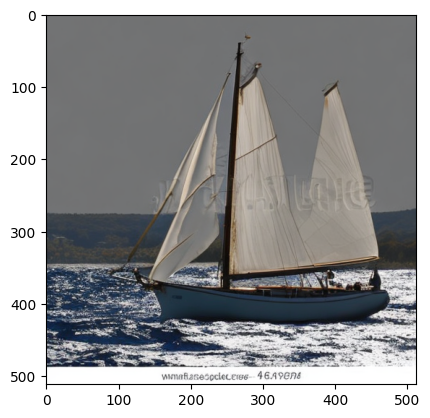

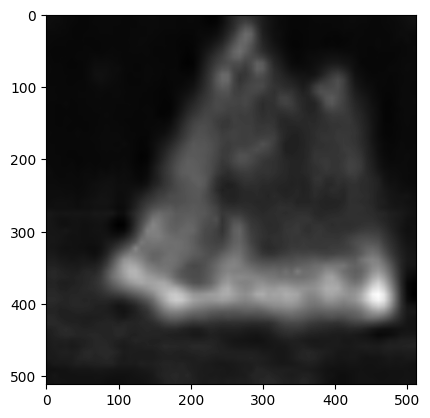

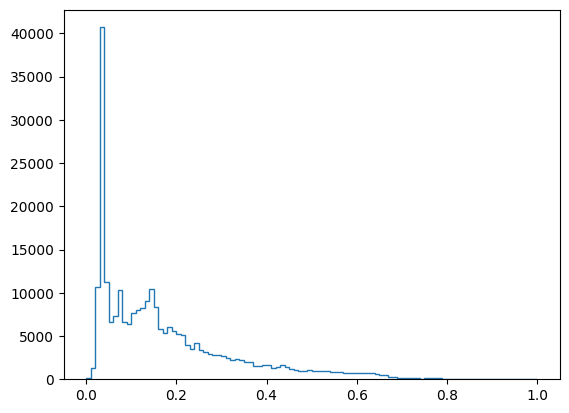

In [84]:
show_img(img)
show_prob(prob)
show_hist2(*np.histogram(prob, bins=bins, range=(0, 1)))

## Tanh2

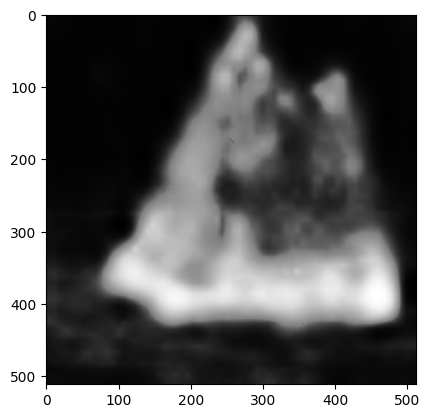

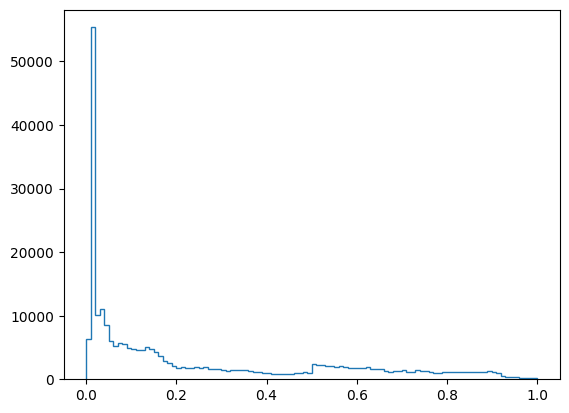

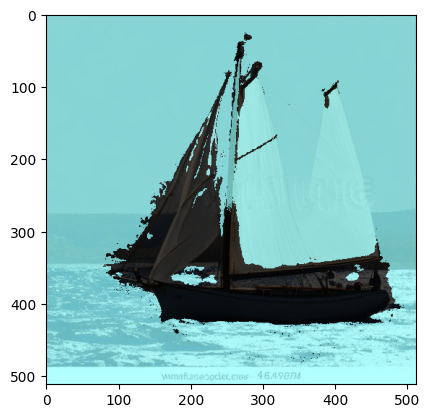

In [85]:
prob_tanh2 = act_tanh2(prob, sat=sat, mid=mid)
show_prob(prob_tanh2)
show_hist2(*np.histogram(prob_tanh2, bins=bins, range=(0, 1)))
prob_post = do_postprocess(prob_tanh2, img_bgr)
label = ternaryzation(prob_post, low_th, high_th)
show_img_with_label(img, label)

## Linear

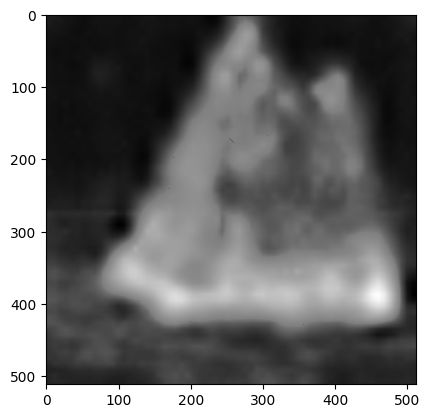

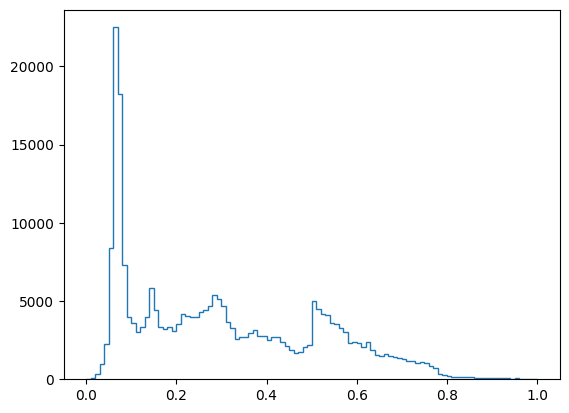

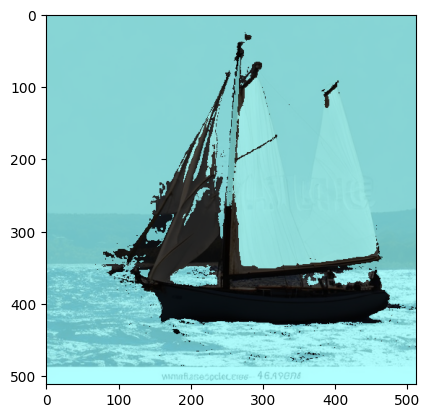

In [86]:
prob_linear = act_linear(prob, mid=mid)
show_prob(prob_linear)
show_hist2(*np.histogram(prob_linear, bins=bins, range=(0, 1)))
prob_post = do_postprocess(prob_linear, img_bgr)
label = ternaryzation(prob_post, low_th, high_th)
show_img_with_label(img, label)

## Trough

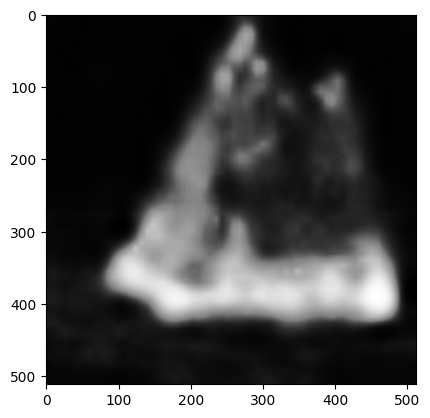

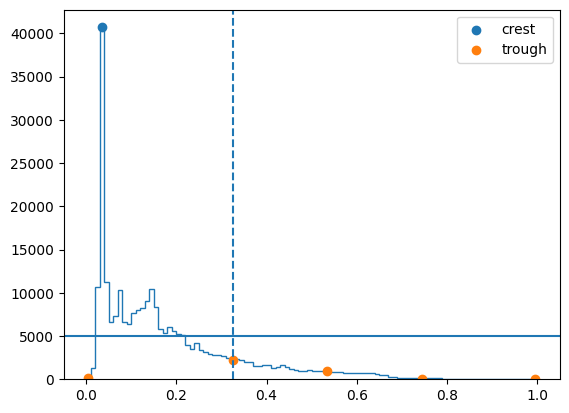

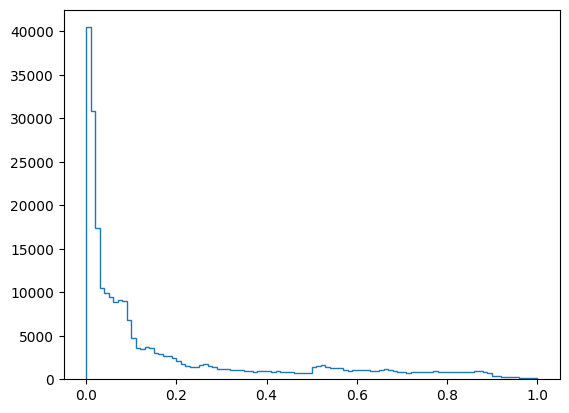

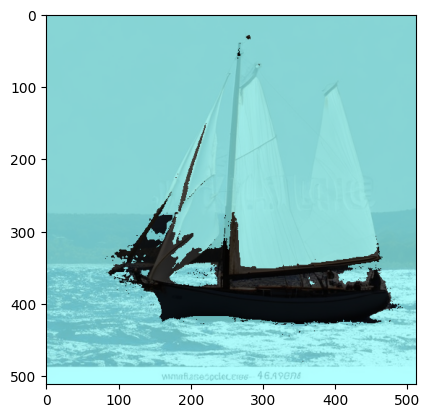

In [87]:
prob_trough, hist_info, crest_info, trough_info, mid = act_trough(prob, sat=sat, win_size=win_size, th=th, debug=True)
show_prob(prob_trough)
show_hist(hist_info, crest_info, trough_info, mid, None, th)
show_hist2(*np.histogram(prob_trough, bins=bins, range=(0, 1)))
prob_post = do_postprocess(prob_trough, img_bgr)
label = ternaryzation(prob_post, low_th, high_th)
show_img_with_label(img, label)

## Trough2

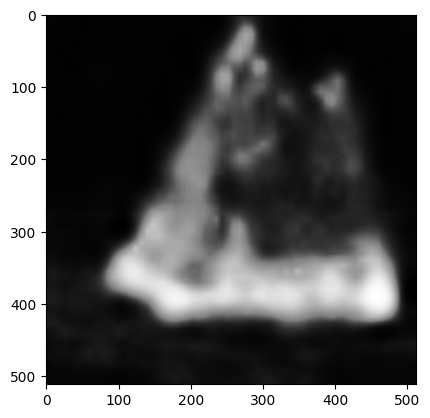

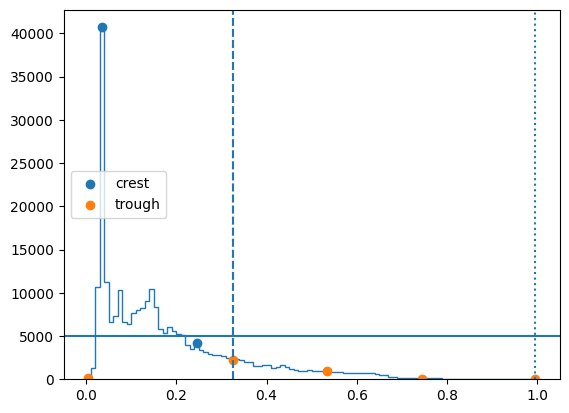

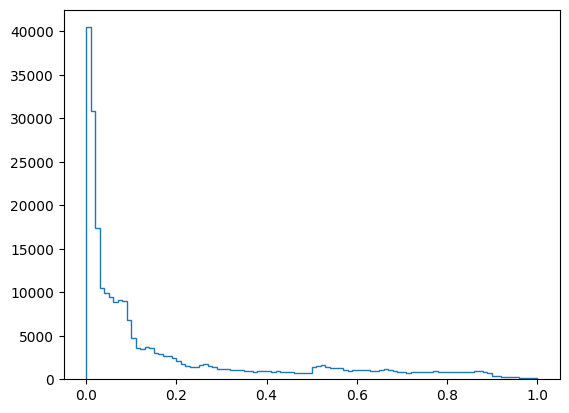

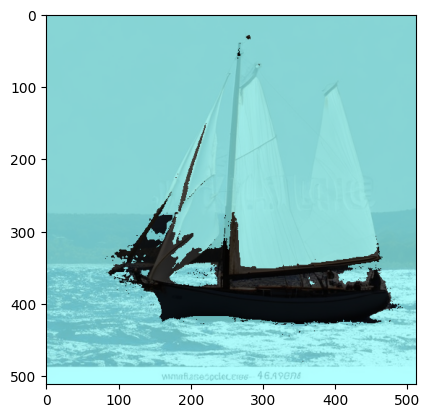

In [88]:
prob_trough, hist_info, crest_info, trough_info, mid, first_trough_positions = act_trough2(prob, th=th, sat=sat,
                                                                                           win_size=win_size,
                                                                                           debug=True)
show_prob(prob_trough)
show_hist(hist_info, crest_info, trough_info, mid, first_trough_positions, th=th)
show_hist2(*np.histogram(prob_trough, bins=bins, range=(0, 1)))
prob_post = do_postprocess(prob_trough, img_bgr)
label = ternaryzation(prob_post, low_th, high_th)
show_img_with_label(img, label)

## Trough3

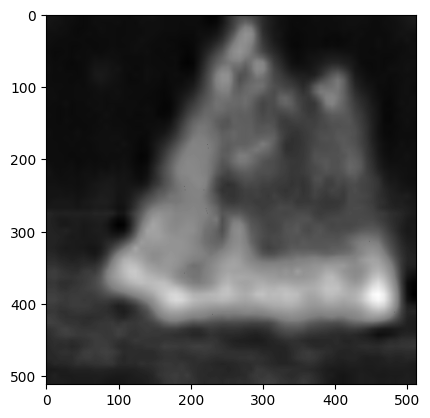

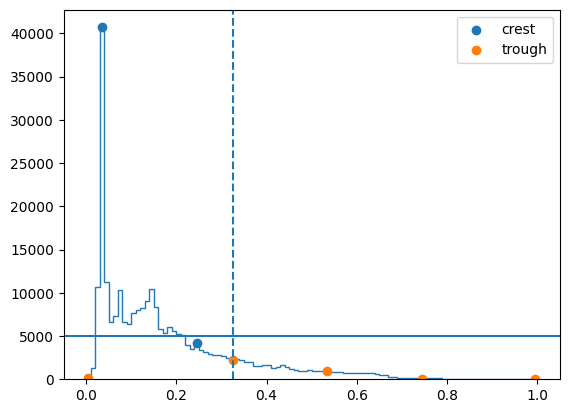

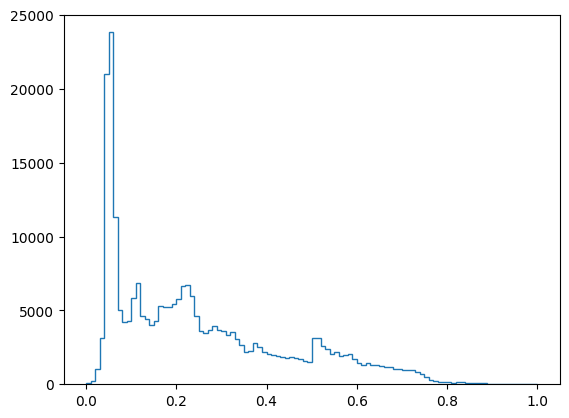

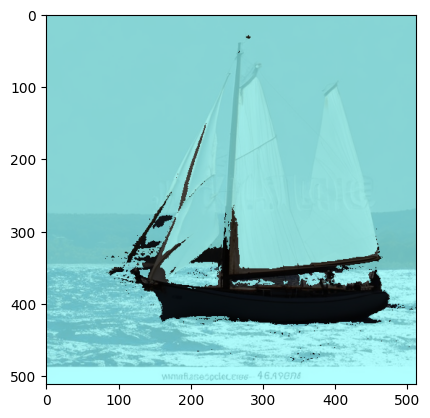

In [89]:
prob_trough, hist_info, crest_info, trough_info, mid = act_trough3(prob, th=th, win_size=win_size, debug=True)
show_prob(prob_trough)
show_hist(hist_info, crest_info, trough_info, mid, None, th=th)
show_hist2(*np.histogram(prob_trough, bins=bins, range=(0, 1)))
prob_post = do_postprocess(prob_trough, img_bgr)
label = ternaryzation(prob_post, low_th, high_th)
show_img_with_label(img, label)

## Valley

0.17500001192092896


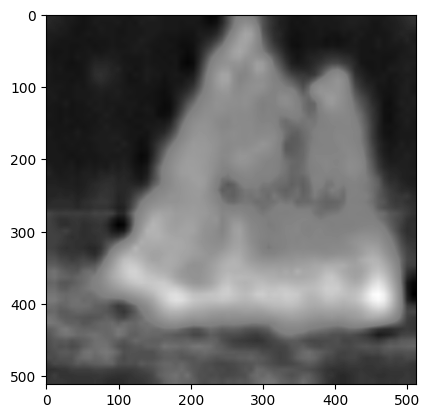

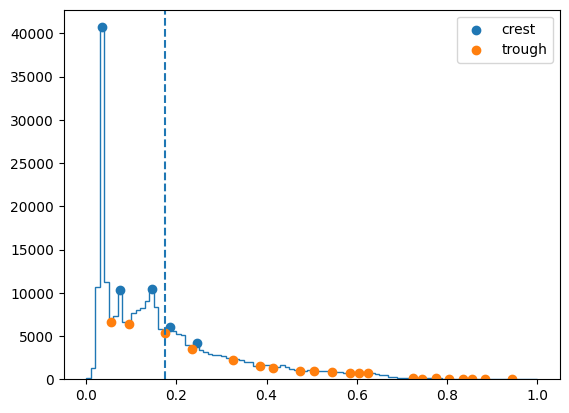

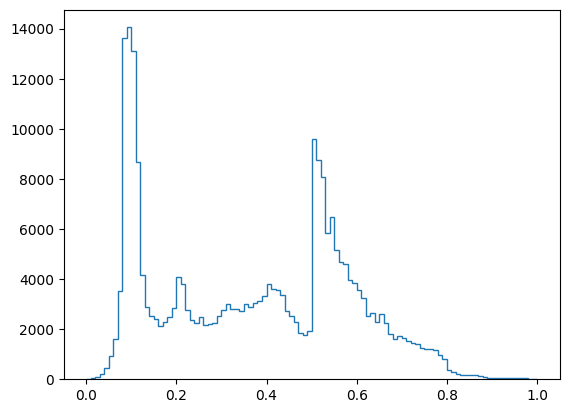

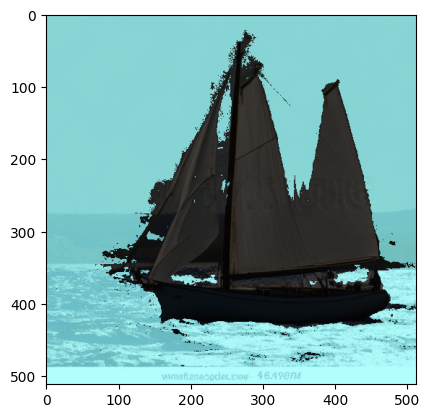

In [90]:
prob_valley, hist_info, crest_info, trough_info, mid = act_valley(prob, vwidth=None, pprom=500, debug=True)
mid = trough_info[0][2]
print(mid)
prob_valley = act_linear(prob, mid)
show_prob(prob_valley)
show_hist(hist_info, crest_info, trough_info, mid, part_trough_positions=None, th=None)
show_hist2(*np.histogram(prob_valley, bins=bins, range=(0, 1)))
prob_post = do_postprocess(prob_valley, img_bgr)
label = ternaryzation(prob_post, low_th, high_th)
show_img_with_label(img, label)